In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
from einops import rearrange, reduce, asnumpy
from collections import defaultdict
import re
import itertools

from vgiwae.utils.stats import load_stats
from vgiwae.utils.plotting import plot_custom_stripplot, plot_cust_boxplot

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

## FID 

In [64]:
seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'uci_gas', 
    'uci_power', 
    'uci_hepmass', 
    'uci_miniboone',
]

models_by_dataset = {}
models_by_dataset['uci_gas'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
# #     {
# #         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
# #         'label_name': 'DeMiss-VAE (second enc, ENCM)'
# #     },
]

models_by_dataset['uci_power'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl_gradclip05',
# #         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM, gradclip=0.5)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_encm_lairdmisr1iter10_k5_stl_gradclip05',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 ENCM gradclip=0.5)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

models_by_dataset['uci_hepmass'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE it10'
    },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

models_by_dataset['uci_miniboone'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=1 clip, gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE it10'
    },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

missingness = ['mis20', 'mis50', 'mis80']

log_dir_template = '../logs/{}/compare/{}/{}/{}/lightning_logs/'

metrics = [
    'fid_score/train',
    'fid_score/val',
    'fid_score/test',
]


model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for seed in seeds:
                log_dir = log_dir_template.format(dataset, miss, model['name'], seed)

                stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                for m in metrics:
                    model_stats[dataset][miss][model['label_name']][m].append(stats[m])

100%|████████████████████████████████████████████████████████| 4/4 [1:24:59<00:00, 1274.97s/it]


In [65]:
dataset_log_frequency = {
    'uci_gas': 5000,
    'uci_power': 5000,
    'uci_hepmass': 5000,
    'uci_miniboone': 550,
}

### Iter vs FID

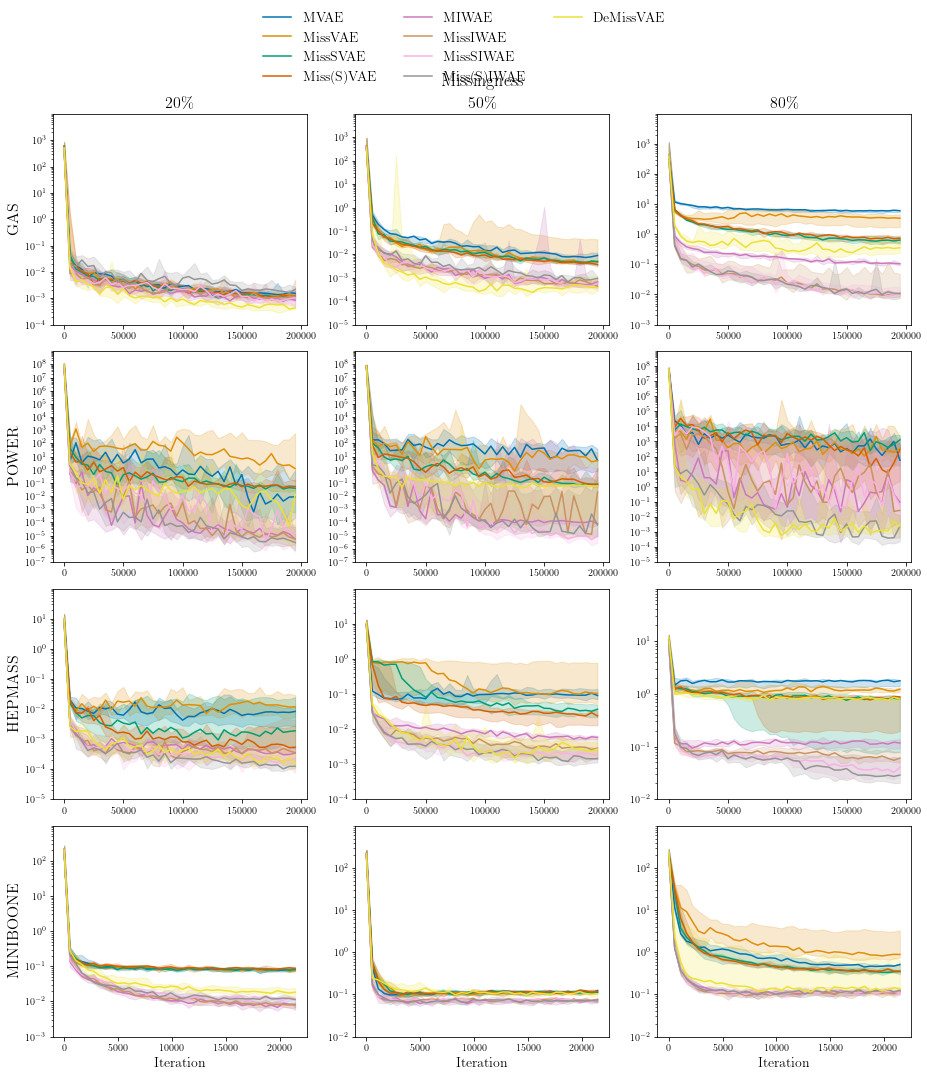

In [66]:
fig, axes = plt.subplots(4, 3, figsize=(13,15), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['uci_gas']))
colors += ['r', 'g', 'b', 'c', 'm']

metric = metrics[2]
use_log_scale = True

for i, dataset in enumerate(datasets):
    for j, miss in enumerate(missingness):
        for m, model in enumerate(models_by_dataset[dataset]):
            stat = model_stats[dataset][miss][model['label_name']][metric]
            stat = np.column_stack(list(itertools.zip_longest(*stat, fillvalue=float('nan'))))
            stat = np.array(stat)
            
            # Fix some weird issue where the metric is stored twice in some log-files
            stat = stat[:, :40]
            
            # Plot in log-domain
            if use_log_scale:
                stat = np.log(stat)
            
            median = np.nanmedian(stat, axis=0)
            low_ci = np.nanquantile(stat, 0.05, axis=0)
            high_ci = np.nanquantile(stat, 0.95, axis=0)
            axes[i][j].plot(np.arange(len(median))*dataset_log_frequency[dataset], 
                            median, color=colors[m], label=model['label_name'])
            axes[i][j].fill_between(np.arange(len(median))*dataset_log_frequency[dataset]
                                    , low_ci, high_ci, color=colors[m], alpha=.2)
        
        if use_log_scale:
            axes[i,j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
            ymin, ymax = axes[i,j].get_ylim()
            tick_range = np.arange(np.floor(ymin), ymax)
            axes[i,j].yaxis.set_ticks(tick_range)
            axes[i,j].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        
        if j == 0:
            axes[i, j].set_ylabel(dataset.split('uci_')[1].upper(), fontsize=16)
        if i == 0:
            axes[i, j].set_title(miss.split('mis')[1]+'\%', fontsize=16)
fig.text(0.52, 0.92, 'Missingness', 
         fontsize=18, ha='center',
         transform=fig.transFigure)
for ax in axes[-1]:
    ax.set_xlabel('Iteration', fontsize=14)
            
handles, labels = axes[0, 0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout(rect=(0, 0, 1, 0.92))

# fig.savefig('figures/uci_complete_test_fid_vs_iterations.pdf', bbox_inches='tight')

### Only last FID

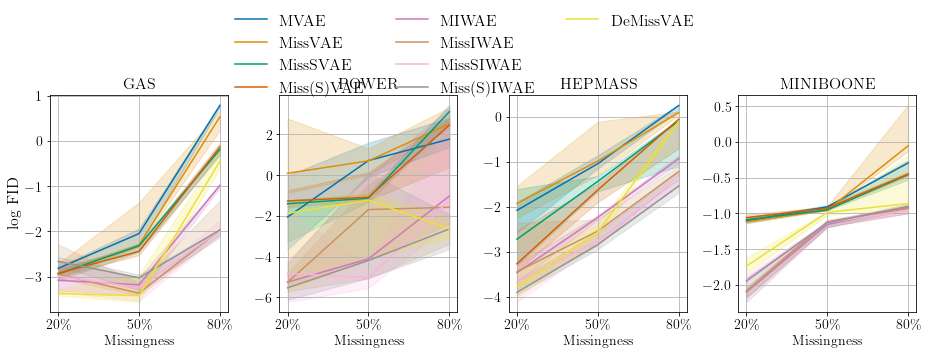

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(13,5), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['uci_gas']))
colors += ['r', 'g', 'b', 'c', 'm']

metric0 = 'fid_score/test'
use_log_scale = True
plot_negative = False

for d, (dataset, data_stats) in enumerate(model_stats.items()):
    model_label_names = [v['label_name'] for v in models_by_dataset[dataset]]
    
    metric_box_data = defaultdict(list)
    missingness_labels = list(data_stats.keys())
    missingness_labels2 = [ml.split('mis')[1]+'\%' for ml in missingness_labels]
    stats = defaultdict(list)
    for i, model in enumerate(model_label_names):
        stats_model = []
        for m in missingness_labels:
            stat = data_stats[m][model][metric0]
            stat = np.column_stack(list(itertools.zip_longest(*stat, fillvalue=float('nan'))))
            # Fix some weird issue where the metric is stored twice in some log-files
            stat = stat[:, :40]
            
            stats_model.append(np.array(stat)[:, -1].flatten())
        stats_model = np.array(stats_model)
        
        if use_log_scale:
            stats_model = np.log(stats_model)
            
        if plot_negative:
            stats_model = -stats_model
        
        median = np.nanmedian(stats_model, axis=-1)
        low_ci = np.nanquantile(stats_model, 0.05, axis=-1)
        high_ci = np.nanquantile(stats_model, 0.95, axis=-1)
        axes[d].plot(missingness_labels2, median, color=colors[i], label=model)
        axes[d].fill_between(missingness_labels2, low_ci, high_ci, color=colors[i], alpha=.2)
        
    axes[d].set_title(dataset.split('uci_')[1].upper(), fontsize=16)
    axes[d].grid()
    axes[d].set_xlabel('Missingness', fontsize=14)
    axes[d].tick_params(axis='both', which='major', labelsize=14)

ylabel = 'FID'
if use_log_scale:
    ylabel = 'log ' + ylabel
if plot_negative:
    ylabel = '- ' + ylabel
axes[0].set_ylabel(ylabel, fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=16)

fig.tight_layout(rect=(0, 0, 1, 0.81))

# fig.savefig('figures/uci_complete_test_logfid_lastiter.pdf', bbox_inches='tight')

## Log-likelihood estimate (IWAE bound)

In [62]:
seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'uci_gas', 
    'uci_power', 
    'uci_hepmass', 
    'uci_miniboone',
]

models_by_dataset = {}
models_by_dataset['uci_gas'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
# #     {
# #         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
# #         'label_name': 'DeMiss-VAE (second enc, ENCM)'
# #     },
]

models_by_dataset['uci_power'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl_gradclip05',
# #         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM, gradclip=0.5)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_encm_lairdmisr1iter10_k5_stl_gradclip05',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 ENCM gradclip=0.5)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

models_by_dataset['uci_hepmass'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

models_by_dataset['uci_miniboone'] = [
    # VAE
    {
        'name': 'vae_z5_encm_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_k5_z1_encm_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_k5_z1_encm_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl',
        'label_name': 'MIWAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_iwae_k5_i1_encm_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_k5_i1_encm_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVB-VAE
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr0clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=0 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=0 gradclip=1)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip)'
#     },
#     {
#         'name': 'mvb2vae_encm_lairdmisr1clip_k5_stl',
#         'label_name': 'DeMiss-VAE (LAIR R=1 clip, ENCM)'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr1clip_k5_stl_gradclip1',
# #         'label_name': 'DeMiss-VAE (LAIR R=1 clip, gradclip=1)'
#         'label_name': 'DeMiss-VAE'
#     },
    {
        'name': 'mvb2vae_lairdmisr1iter10_k5_stl_gradclip1',
#         'label_name': 'DeMiss-VAE (LAIR R=1 iter=10 gradclip=1)'
#         'label_name': 'DeMiss-VAE it10'
        'label_name': 'DeMissVAE'
    },
#     {
#         'name': 'mvb2vae_lairdmisr0_k5_stl_lr1e-4',
#         'label_name': 'DeMiss-VAE (LAIR R=0, lr=1e-4)'
#     },
#     {
#         'name': 'mvb2vae_encm_with_second_enc_k5_stl',
#         'label_name': 'DeMiss-VAE (second enc, ENCM)'
#     },
]

missingness = ['mis20', 'mis50', 'mis80']

log_dir_template = '../logs/{}/compare/refit_encoder_testcomp/{}/{}/{}/lightning_logs/'

metrics = [
    'est_loglik/test_epoch',
]


loglik_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for seed in seeds:
                log_dir = log_dir_template.format(dataset, miss, model['name'], seed)

                stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                for m in metrics:
                    loglik_model_stats[dataset][miss][model['label_name']][m].append(stats[m])

 75%|████████████████████████████████████████████▎              | 3/4 [10:07<03:15, 195.33s/it]

Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_vae_k5_z1_encm_stl/seed_m20220118_d20220118/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_vae_k5_z1_encm_stl/seed_m2022011811_d2022011811/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_vae_k5_z1_encm_stl/seed_m2022011822_d2022011822/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_vae_k5_z1_encm_stl/seed_m2022011833_d2022011833/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_vae_k5_z1_encm_stl/seed_m2022011844_d2022011844/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_iwae_k5_i1_encm_stl/seed_m20220118_d20220118/lightning_logs/
Multiple versions in ../logs/uci_miniboone/compare/refit_encoder_testcomp/mis20/multiple_

100%|███████████████████████████████████████████████████████████| 4/4 [10:39<00:00, 159.91s/it]


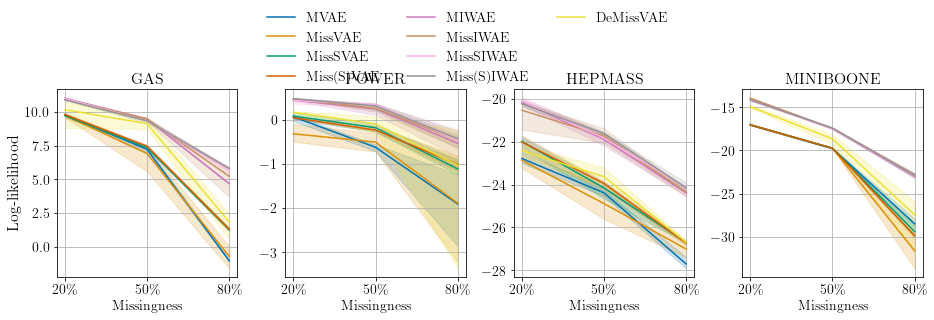

In [63]:
fig, axes = plt.subplots(1, 4, figsize=(13,4.5), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['uci_gas']))
colors += ['r', 'g', 'b', 'c', 'm']

metric0 = metrics[0]

for d, (dataset, data_stats) in enumerate(loglik_model_stats.items()):
    model_label_names = [v['label_name'] for v in models_by_dataset[dataset]]
    
    metric_box_data = defaultdict(list)
    missingness_labels = list(data_stats.keys())
    missingness_labels2 = [ml.split('mis')[1]+'\%' for ml in missingness_labels]
    stats = defaultdict(list)
    for i, model in enumerate(model_label_names):
        stats_model = []
        for m in missingness_labels:
            stats_model.append(np.array(data_stats[m][model][metric0]).flatten())
        stats_model = np.array(stats_model)
        
        median = np.nanmean(stats_model, axis=-1)
        low_ci = np.nanquantile(stats_model, 0.05, axis=-1)
        high_ci = np.nanquantile(stats_model, 0.95, axis=-1)
        axes[d].plot(missingness_labels2, median, color=colors[i], label=model)
        axes[d].fill_between(missingness_labels2, low_ci, high_ci, color=colors[i], alpha=.2)
        
    axes[d].set_title(dataset.split('uci_')[1].upper(), fontsize=16)
    axes[d].grid()
    axes[d].set_xlabel('Missingness', fontsize=14)
    axes[d].tick_params(axis='both', which='major', labelsize=14)

axes[0].set_ylabel('Log-likelihood', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout(rect=(0, 0, 1, 0.81))

# fig.savefig('figures/uci_complete_test_loglikelihood_lastiter.pdf', bbox_inches='tight')